In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

class BaryInterp(object):
  def __init__(self,x,f):
    self.x = x
    self.f = f
    self.weights = np.zeros(len(x))

    
  ##TO BE TAKEN CARE OF  
  def update(self,x_update,f_update):
    self.x = np.append(self.x,x_update)
    self.f = np.append(self.f,f_update)
    sort_ind = np.argsort(self.x)
    self.x = np.sort(self.x)
    self.f = self.f[sort_ind]
    self.weights = np.zeros(len(x))
    
  def calc_weights(self):
    N = len(self.x)
    W = np.ones([N,N])
    for i in range(1,len(self.x)):
        W[i,:i] = self.x[:i] - self.x[i]
        W[i,i] = ((-1)**i)*np.prod(W[i,:i])
    
    W[N-1,:] = np.prod(W,axis=0)
    self.weights = (1.0/W)[-1,:]
    
  def interp_lagrange(self,x_arg):
    self.calc_weights()
    
    interp_eval = np.zeros(len(x_arg))
    
    for i in range(len(x_arg)):    
        if(np.amin(np.abs(x_arg[i] - self.x)) == 0): interp_eval[i] = self.f[np.argmin(np.abs(x_arg[i] - self.x))]
        else: interp_eval[i] += np.sum((self.weights[:]*self.f[:]/(x_arg[i] - self.x[:])))/np.sum((self.weights[:]/(x_arg[i] - self.x[:])))
    return interp_eval


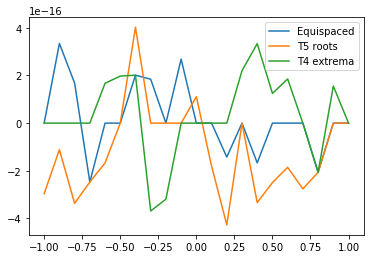

In [2]:
import numpy.polynomial.chebyshev as cheb

nodes1 = np.linspace(-1,1,5) 

nodes2 = cheb.chebroots((0, 0, 0, 0, 0, 1))

x2 = np.linspace(-1,1,21)

val_cheb_4 = cheb.chebval(x2,[0, 0, 0, 0, 1])
mask = np.zeros(len(x2))
nodes3 = np.zeros(5)
for i in range(5):
    max_ind = np.argmax(np.abs(val_cheb_4))
    mask[max_ind] = 1
    val_cheb_4 = np.ma.array(val_cheb_4, mask = mask)
    nodes3[i] = x2[max_ind]

p = np.poly1d([5,4,3,2,1])

b1 = BaryInterp(nodes1,p(nodes1))

b2 = BaryInterp(nodes2,p(nodes2))

b3 = BaryInterp(nodes3,p(nodes3))

plt.plot(x2, (p(x2) - b1.interp_lagrange(x2))/p(x2),label='Equispaced')

plt.plot(x2, (p(x2) - b2.interp_lagrange(x2))/p(x2),label='T5 roots')

plt.plot(x2, (p(x2) - b3.interp_lagrange(x2))/p(x2),label='T4 extrema')

plt.legend()

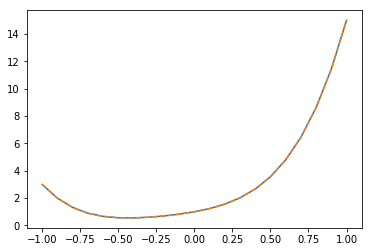

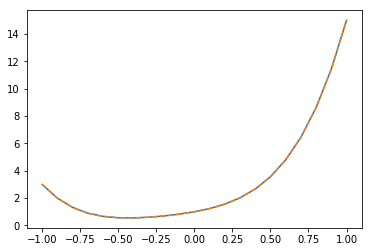

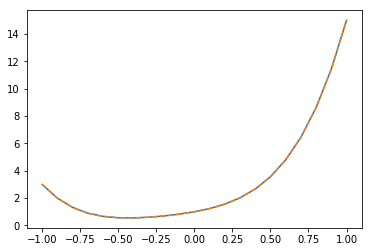

In [3]:
plt.plot(x2, b1.interp_lagrange(x2))
plt.plot(x2, p(x2),'--')

plt.figure()
plt.plot(x2, b2.interp_lagrange(x2))
plt.plot(x2, p(x2),'--')

plt.figure()
plt.plot(x2, b3.interp_lagrange(x2))
plt.plot(x2, p(x2),'--')